In [1]:
import os
import gc
import torch
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_LAUNCH_BLOCKING'] = '0'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset

# DDPM (Denoising Diffusion Probabilistic Models) on Fashion-MNIST
### DDPM learns to reverse a fixed Markov chain that gradually adds Gaussian noise to the data

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
from scipy.linalg import sqrtm
from tqdm import tqdm
import copy
import os

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Step 1: Load Fashion-MNIST Dataset
### Using the same 30,000 samples subset for faster training

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

np.random.seed(42)
indices = np.random.choice(len(train_dataset), size=30000, replace=False)
train_subset = Subset(train_dataset, indices)

batch_size = 256
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

train_data = train_dataset.data[indices].float() / 255.0 * 2.0 - 1.0
train_labels = train_dataset.targets[indices]

test_data = test_dataset.data.float() / 255.0 * 2.0 - 1.0
print(f"Training set size: {len(train_subset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")
print(f"Data range: [{train_dataset[0][0].min():.3f}, {train_dataset[0][0].max():.3f}]")

Training set size: 30000
Test set size: 10000
Image shape: torch.Size([1, 28, 28])
Data range: [-1.000, 1.000]


## Step 2: Build DDPM Model and Components

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class EMA:
    """Exponential Moving Average for model parameters"""
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())


class SelfAttention(nn.Module):
    """Multi-head self-attention module"""
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


class DoubleConv(nn.Module):
    """Double convolution block with optional residual connection"""
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    """Downsampling block with time embedding"""
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    """Upsampling block with time embedding"""
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        # Match spatial size with skip connection
        if x.shape[-2:] != skip_x.shape[-2:]:
            diff_y = skip_x.size(2) - x.size(2)
            diff_x = skip_x.size(3) - x.size(3)
            x = F.pad(x, [diff_x // 2, diff_x - diff_x // 2, diff_y // 2, diff_y - diff_y // 2])
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class UNet(nn.Module):
    """U-Net architecture for DDPM noise prediction"""
    def __init__(self, c_in=1, c_out=1, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        
        # Encoder path
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 14)  # 28/2=14
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 7)   # 14/2=7
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 3)   # 7/2=3

        # Bottleneck
        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        # Decoder path
        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 7)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 14)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 28)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        """Sinusoidal positional encoding for timestep"""
        inv_freq = 1.0 / (
            10000 ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        """Forward pass predicting noise
        Args:
            x: Noisy image [B, C, H, W]
            t: Timestep [B] (integer timestep indices)
        Returns:
            predicted_noise: [B, C, H, W]
        """
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

In [6]:
class Diffusion:
    """DDPM diffusion process"""
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=28, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        # Prepare noise schedule
        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        """Linear beta schedule"""
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        """Add noise to images at timestep t (forward process)
        Args:
            x: Clean images [B, C, H, W]
            t: Timesteps [B]
        Returns:
            x_t: Noisy images [B, C, H, W]
            noise: The noise added [B, C, H, W]
        """
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        noise = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * noise, noise

    def sample_timesteps(self, n):
        """Sample random timesteps"""
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n, use_ema=False):
        """Generate samples using reverse process
        Args:
            model: Trained UNet model
            n: Number of samples to generate
            use_ema: Whether to use EMA model
        Returns:
            samples: Generated images [N, C, H, W]
        """
        print(f"Sampling {n} new images...")
        model.eval()
        with torch.no_grad():
            # Start from pure noise
            x = torch.randn((n, 1, self.img_size, self.img_size)).to(self.device)
            
            # Reverse diffusion process
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0, desc="Sampling"):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                
                # Reverse step
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        
        model.train()
        # Normalize to [0, 1]
        x = (x.clamp(-1, 1) + 1) / 2
        return x

In [7]:
# Test the model
model = UNet(c_in=1, c_out=1, time_dim=256, device=device).to(device)
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Test forward pass
test_batch_size = 4
test_x = torch.randn(test_batch_size, 1, 28, 28).to(device)
test_t = torch.randint(0, 1000, (test_batch_size,)).to(device)

print(f"\nTest forward pass:")
print(f"Input shape:  {test_x.shape}")
print(f"Timestep shape:  {test_t.shape}")

with torch.no_grad():
    output = model(test_x, test_t)

print(f"Output shape: {output.shape}")

Total parameters: 23,331,457

Test forward pass:
Input shape:  torch.Size([4, 1, 28, 28])
Timestep shape:  torch.Size([4])
Output shape: torch.Size([4, 1, 28, 28])


## Step 3: Training Functions

In [8]:
def train_ddpm(model, dataloader, diffusion, n_epochs=50, lr=3e-4, use_ema=True, ema_beta=0.995, verbose=True):
    """Train DDPM model
    Args:
        model: UNet model
        dataloader: Training data loader
        diffusion: Diffusion process
        n_epochs: Number of training epochs
        lr: Learning rate
        use_ema: Whether to use EMA
        ema_beta: EMA decay rate
        verbose: Print progress
    Returns:
        losses: Training losses
        ema_model: EMA model (if use_ema=True)
    """
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    mse = nn.MSELoss()
    
    # Initialize EMA
    ema = None
    ema_model = None
    if use_ema:
        ema_model = copy.deepcopy(model).eval()
        ema = EMA(ema_beta)
    
    losses = []
    model.train()
    
    for epoch in range(n_epochs):
        epoch_losses = []
        
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{n_epochs}") if verbose else dataloader
        for batch_x, _ in pbar:
            batch_x = batch_x.to(device)
            
            # Sample random timesteps
            t = diffusion.sample_timesteps(batch_x.shape[0]).to(device)
            
            # Add noise to images
            x_t, noise = diffusion.noise_images(batch_x, t)
            
            # Predict noise
            predicted_noise = model(x_t, t)
            
            # Compute loss
            loss = mse(noise, predicted_noise)
            
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Update EMA
            if use_ema:
                ema.step_ema(ema_model, model)
            
            epoch_losses.append(loss.item())
            
            if verbose and isinstance(pbar, tqdm):
                pbar.set_postfix({'loss': f'{loss.item():.4f}', 'lr': f'{scheduler.get_last_lr()[0]:.6f}'})
        
        scheduler.step()
        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        
        if verbose:
            print(f"Epoch {epoch+1}/{n_epochs} - avg loss: {avg_loss:.4f}")
    
    return losses, ema_model

## Step 4: Train DDPM Model

Training DDPM model on Fashion-MNIST...
Total training samples: 30000
Noise steps: 1000
Beta schedule: [0.0001, 0.02]


Epoch 1/50: 100%|██████████| 118/118 [00:32<00:00,  3.67it/s, loss=0.0540, lr=0.000300]


Epoch 1/50 - avg loss: 0.2931


Epoch 2/50: 100%|██████████| 118/118 [00:31<00:00,  3.70it/s, loss=0.0596, lr=0.000300]


Epoch 2/50 - avg loss: 0.0680


Epoch 3/50: 100%|██████████| 118/118 [00:31<00:00,  3.69it/s, loss=0.0533, lr=0.000299]


Epoch 3/50 - avg loss: 0.0597


Epoch 4/50: 100%|██████████| 118/118 [00:32<00:00,  3.67it/s, loss=0.0504, lr=0.000297]


Epoch 4/50 - avg loss: 0.0575


Epoch 5/50: 100%|██████████| 118/118 [00:32<00:00,  3.66it/s, loss=0.0594, lr=0.000295]


Epoch 5/50 - avg loss: 0.0545


Epoch 6/50: 100%|██████████| 118/118 [00:32<00:00,  3.66it/s, loss=0.0395, lr=0.000293]


Epoch 6/50 - avg loss: 0.0500


Epoch 7/50: 100%|██████████| 118/118 [00:32<00:00,  3.66it/s, loss=0.0443, lr=0.000289]


Epoch 7/50 - avg loss: 0.0489


Epoch 8/50: 100%|██████████| 118/118 [00:32<00:00,  3.65it/s, loss=0.0450, lr=0.000286]


Epoch 8/50 - avg loss: 0.0479


Epoch 9/50: 100%|██████████| 118/118 [00:32<00:00,  3.64it/s, loss=0.0473, lr=0.000281]


Epoch 9/50 - avg loss: 0.0454


Epoch 10/50: 100%|██████████| 118/118 [00:32<00:00,  3.65it/s, loss=0.0320, lr=0.000277]


Epoch 10/50 - avg loss: 0.0447


Epoch 11/50: 100%|██████████| 118/118 [00:32<00:00,  3.64it/s, loss=0.0573, lr=0.000271]


Epoch 11/50 - avg loss: 0.0445


Epoch 12/50: 100%|██████████| 118/118 [00:32<00:00,  3.64it/s, loss=0.0393, lr=0.000266]


Epoch 12/50 - avg loss: 0.0428


Epoch 13/50: 100%|██████████| 118/118 [00:32<00:00,  3.64it/s, loss=0.0387, lr=0.000259]


Epoch 13/50 - avg loss: 0.0427


Epoch 14/50: 100%|██████████| 118/118 [00:32<00:00,  3.64it/s, loss=0.0363, lr=0.000253]


Epoch 14/50 - avg loss: 0.0418


Epoch 15/50: 100%|██████████| 118/118 [00:32<00:00,  3.64it/s, loss=0.0222, lr=0.000246]


Epoch 15/50 - avg loss: 0.0415


Epoch 16/50: 100%|██████████| 118/118 [00:32<00:00,  3.65it/s, loss=0.0296, lr=0.000238]


Epoch 16/50 - avg loss: 0.0415


Epoch 17/50: 100%|██████████| 118/118 [00:32<00:00,  3.64it/s, loss=0.0401, lr=0.000230]


Epoch 17/50 - avg loss: 0.0411


Epoch 18/50: 100%|██████████| 118/118 [00:32<00:00,  3.62it/s, loss=0.0271, lr=0.000222]


Epoch 18/50 - avg loss: 0.0411


Epoch 19/50: 100%|██████████| 118/118 [00:32<00:00,  3.62it/s, loss=0.0644, lr=0.000214]


Epoch 19/50 - avg loss: 0.0409


Epoch 20/50: 100%|██████████| 118/118 [00:32<00:00,  3.63it/s, loss=0.0308, lr=0.000205]


Epoch 20/50 - avg loss: 0.0405


Epoch 21/50: 100%|██████████| 118/118 [00:32<00:00,  3.62it/s, loss=0.0497, lr=0.000196]


Epoch 21/50 - avg loss: 0.0403


Epoch 22/50: 100%|██████████| 118/118 [00:32<00:00,  3.63it/s, loss=0.0218, lr=0.000187]


Epoch 22/50 - avg loss: 0.0400


Epoch 23/50: 100%|██████████| 118/118 [00:32<00:00,  3.63it/s, loss=0.0291, lr=0.000178]


Epoch 23/50 - avg loss: 0.0396


Epoch 24/50: 100%|██████████| 118/118 [00:32<00:00,  3.63it/s, loss=0.0240, lr=0.000169]


Epoch 24/50 - avg loss: 0.0396


Epoch 25/50: 100%|██████████| 118/118 [00:32<00:00,  3.62it/s, loss=0.0513, lr=0.000159]


Epoch 25/50 - avg loss: 0.0390


Epoch 26/50: 100%|██████████| 118/118 [00:32<00:00,  3.63it/s, loss=0.0280, lr=0.000150]


Epoch 26/50 - avg loss: 0.0380


Epoch 27/50: 100%|██████████| 118/118 [00:32<00:00,  3.62it/s, loss=0.0334, lr=0.000141]


Epoch 27/50 - avg loss: 0.0391


Epoch 28/50: 100%|██████████| 118/118 [00:32<00:00,  3.62it/s, loss=0.0443, lr=0.000131]


Epoch 28/50 - avg loss: 0.0385


Epoch 29/50: 100%|██████████| 118/118 [00:32<00:00,  3.63it/s, loss=0.0412, lr=0.000122]


Epoch 29/50 - avg loss: 0.0385


Epoch 30/50: 100%|██████████| 118/118 [00:32<00:00,  3.62it/s, loss=0.0227, lr=0.000113]


Epoch 30/50 - avg loss: 0.0384


Epoch 31/50: 100%|██████████| 118/118 [00:32<00:00,  3.62it/s, loss=0.0326, lr=0.000104]


Epoch 31/50 - avg loss: 0.0390


Epoch 32/50: 100%|██████████| 118/118 [00:32<00:00,  3.62it/s, loss=0.0286, lr=0.000095]


Epoch 32/50 - avg loss: 0.0377


Epoch 33/50: 100%|██████████| 118/118 [00:32<00:00,  3.62it/s, loss=0.0359, lr=0.000086]


Epoch 33/50 - avg loss: 0.0386


Epoch 34/50: 100%|██████████| 118/118 [00:32<00:00,  3.62it/s, loss=0.0321, lr=0.000078]


Epoch 34/50 - avg loss: 0.0375


Epoch 35/50: 100%|██████████| 118/118 [00:32<00:00,  3.63it/s, loss=0.0333, lr=0.000070]


Epoch 35/50 - avg loss: 0.0378


Epoch 36/50: 100%|██████████| 118/118 [00:32<00:00,  3.62it/s, loss=0.0405, lr=0.000062]


Epoch 36/50 - avg loss: 0.0376


Epoch 37/50: 100%|██████████| 118/118 [00:32<00:00,  3.63it/s, loss=0.0391, lr=0.000054]


Epoch 37/50 - avg loss: 0.0373


Epoch 38/50: 100%|██████████| 118/118 [00:32<00:00,  3.62it/s, loss=0.0398, lr=0.000047]


Epoch 38/50 - avg loss: 0.0372


Epoch 39/50: 100%|██████████| 118/118 [00:32<00:00,  3.62it/s, loss=0.0231, lr=0.000041]


Epoch 39/50 - avg loss: 0.0368


Epoch 40/50: 100%|██████████| 118/118 [00:32<00:00,  3.63it/s, loss=0.0375, lr=0.000034]


Epoch 40/50 - avg loss: 0.0376


Epoch 41/50: 100%|██████████| 118/118 [00:32<00:00,  3.60it/s, loss=0.0277, lr=0.000029]


Epoch 41/50 - avg loss: 0.0369


Epoch 42/50: 100%|██████████| 118/118 [00:32<00:00,  3.61it/s, loss=0.0304, lr=0.000023]


Epoch 42/50 - avg loss: 0.0374


Epoch 43/50: 100%|██████████| 118/118 [00:32<00:00,  3.61it/s, loss=0.0382, lr=0.000019]


Epoch 43/50 - avg loss: 0.0369


Epoch 44/50: 100%|██████████| 118/118 [00:32<00:00,  3.62it/s, loss=0.0378, lr=0.000014]


Epoch 44/50 - avg loss: 0.0374


Epoch 45/50: 100%|██████████| 118/118 [00:32<00:00,  3.62it/s, loss=0.0417, lr=0.000011]


Epoch 45/50 - avg loss: 0.0364


Epoch 46/50: 100%|██████████| 118/118 [00:32<00:00,  3.62it/s, loss=0.0330, lr=0.000007]


Epoch 46/50 - avg loss: 0.0361


Epoch 47/50: 100%|██████████| 118/118 [00:32<00:00,  3.62it/s, loss=0.0261, lr=0.000005]


Epoch 47/50 - avg loss: 0.0368


Epoch 48/50: 100%|██████████| 118/118 [00:32<00:00,  3.62it/s, loss=0.0363, lr=0.000003]


Epoch 48/50 - avg loss: 0.0366


Epoch 49/50: 100%|██████████| 118/118 [00:32<00:00,  3.62it/s, loss=0.0462, lr=0.000001]


Epoch 49/50 - avg loss: 0.0369


Epoch 50/50: 100%|██████████| 118/118 [00:32<00:00,  3.62it/s, loss=0.0305, lr=0.000000]


Epoch 50/50 - avg loss: 0.0370


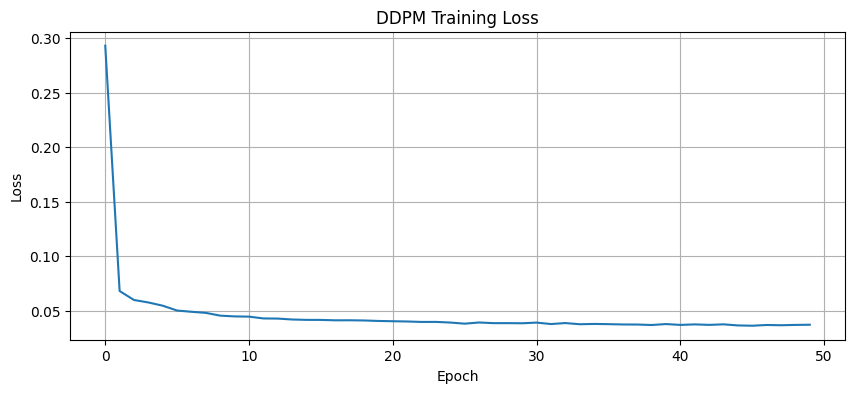


Final loss: 0.0370


In [9]:
# Initialize model and diffusion
ddpm_model = UNet(c_in=1, c_out=1, time_dim=256, device=device).to(device)
diffusion = Diffusion(noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=28, device=device)

print("Training DDPM model on Fashion-MNIST...")
print(f"Total training samples: {len(train_subset)}")
print(f"Noise steps: {diffusion.noise_steps}")
print(f"Beta schedule: [{diffusion.beta_start}, {diffusion.beta_end}]")

training_losses, ema_model = train_ddpm(
    ddpm_model,
    train_loader,
    diffusion,
    n_epochs=50,
    lr=3e-4,
    use_ema=True,
    ema_beta=0.995,
    verbose=True
)

plt.figure(figsize=(10, 4))
plt.plot(training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('DDPM Training Loss')
plt.grid(True)
plt.show()

print(f"\nFinal loss: {training_losses[-1]:.4f}")

## Step 5: Test Denoising Capability

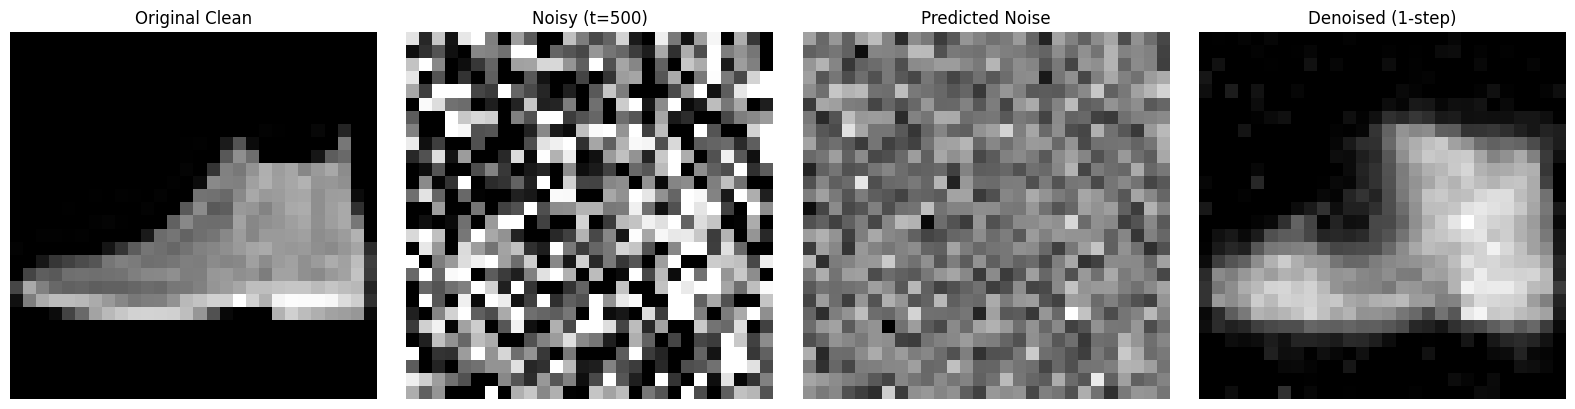

In [10]:
ddpm_model.eval()
with torch.no_grad():
    # Get a real image
    real_img = next(iter(test_loader))[0][:1].to(device)
    
    # Add noise at timestep 500 (middle of diffusion process)
    t = torch.tensor([500]).to(device)
    noisy_img, noise = diffusion.noise_images(real_img, t)
    
    # Predict noise
    predicted_noise = ddpm_model(noisy_img, t)
    
    # Simple denoising (one-step approximation)
    alpha_hat = diffusion.alpha_hat[t][:, None, None, None]
    denoised = (noisy_img - torch.sqrt(1 - alpha_hat) * predicted_noise) / torch.sqrt(alpha_hat)
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    axes[0].imshow((real_img[0, 0].cpu() + 1) / 2, cmap='gray')
    axes[0].set_title('Original Clean')
    axes[0].axis('off')
    
    axes[1].imshow(torch.clamp((noisy_img[0, 0].cpu() + 1) / 2, 0, 1), cmap='gray')
    axes[1].set_title(f'Noisy (t={t.item()})')
    axes[1].axis('off')
    
    axes[2].imshow((predicted_noise[0, 0].cpu() + 1) / 2, cmap='gray')
    axes[2].set_title('Predicted Noise')
    axes[2].axis('off')
    
    axes[3].imshow(torch.clamp((denoised[0, 0].cpu() + 1) / 2, 0, 1), cmap='gray')
    axes[3].set_title('Denoised (1-step)')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()

## Step 6: Generate Samples

Generating samples using DDPM reverse process...
Sampling 16 new images...


Sampling: 999it [00:08, 114.51it/s]


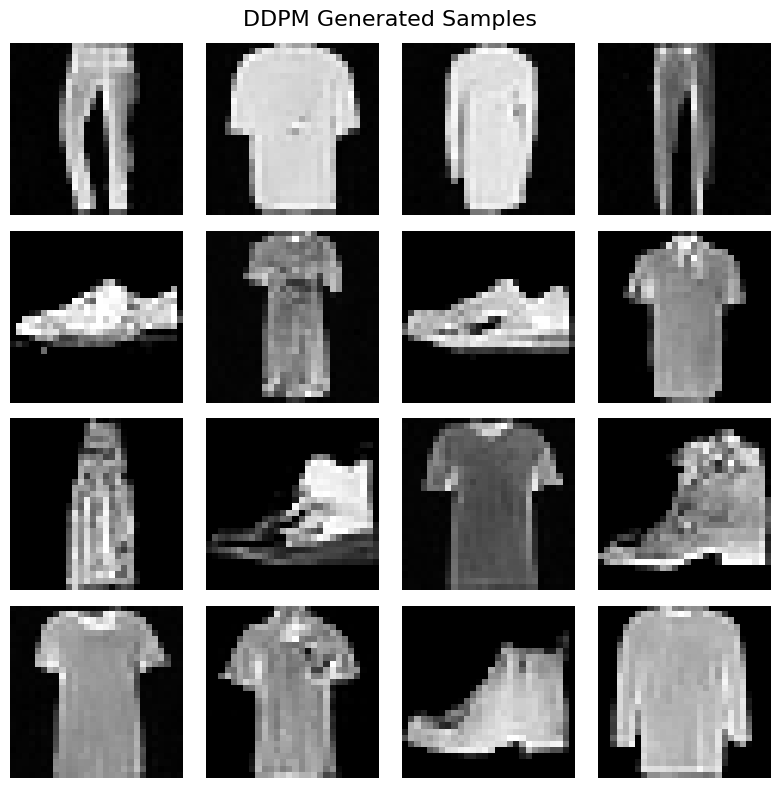

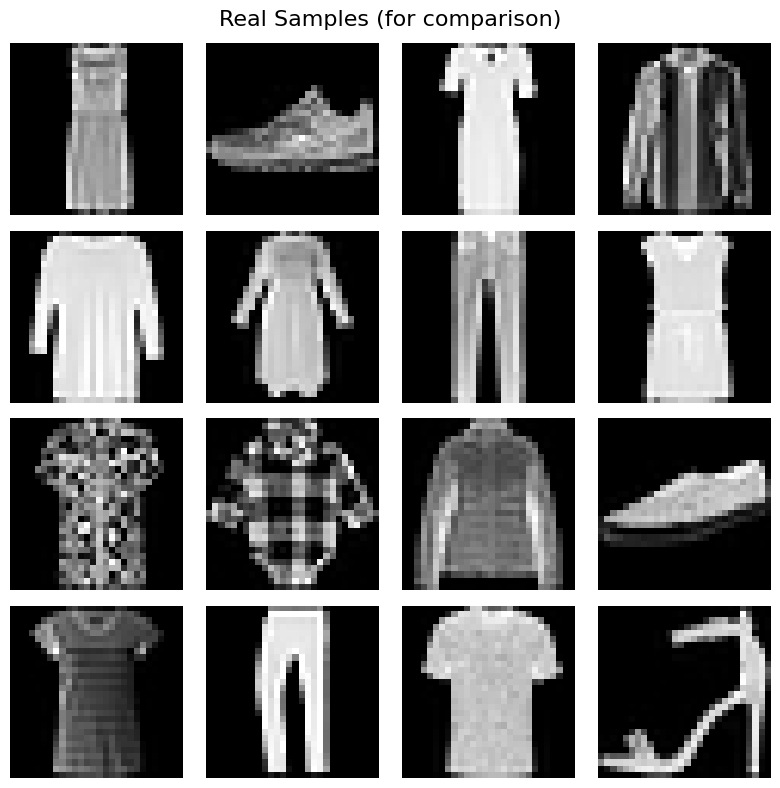

In [11]:
print("Generating samples using DDPM reverse process...")

# Use EMA model for better quality
model_for_sampling = ema_model if ema_model is not None else ddpm_model

samples = diffusion.sample(model_for_sampling, n=16, use_ema=True)
samples = samples.cpu()

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(16):
    axes[i // 4, i % 4].imshow(samples[i, 0].numpy(), cmap='gray')
    axes[i // 4, i % 4].axis('off')
plt.suptitle('DDPM Generated Samples', fontsize=16)
plt.tight_layout()
plt.show()

# Show real samples for comparison
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
real_samples = next(iter(train_loader))[0][:16]
real_samples = (real_samples + 1) / 2
for i in range(16):
    axes[i // 4, i % 4].imshow(real_samples[i, 0].numpy(), cmap='gray')
    axes[i // 4, i % 4].axis('off')
plt.suptitle('Real Samples (for comparison)', fontsize=16)
plt.tight_layout()
plt.show()

## Step 7: Evaluation of Generated Samples

In [12]:
# Generate samples for evaluation
print("Generating 100 samples for evaluation...")
model_for_sampling = ema_model if ema_model is not None else ddpm_model

generated_samples = diffusion.sample(model_for_sampling, n=1000, use_ema=True)
generated_samples = generated_samples.cpu().numpy()

print(f"Generated samples shape: {generated_samples.shape}")
print(f"Generated samples range: [{generated_samples.min():.3f}, {generated_samples.max():.3f}]")

Generating 100 samples for evaluation...
Sampling 1000 new images...


Sampling: 999it [06:28,  2.57it/s]


Generated samples shape: (1000, 1, 28, 28)
Generated samples range: [0.000, 1.000]


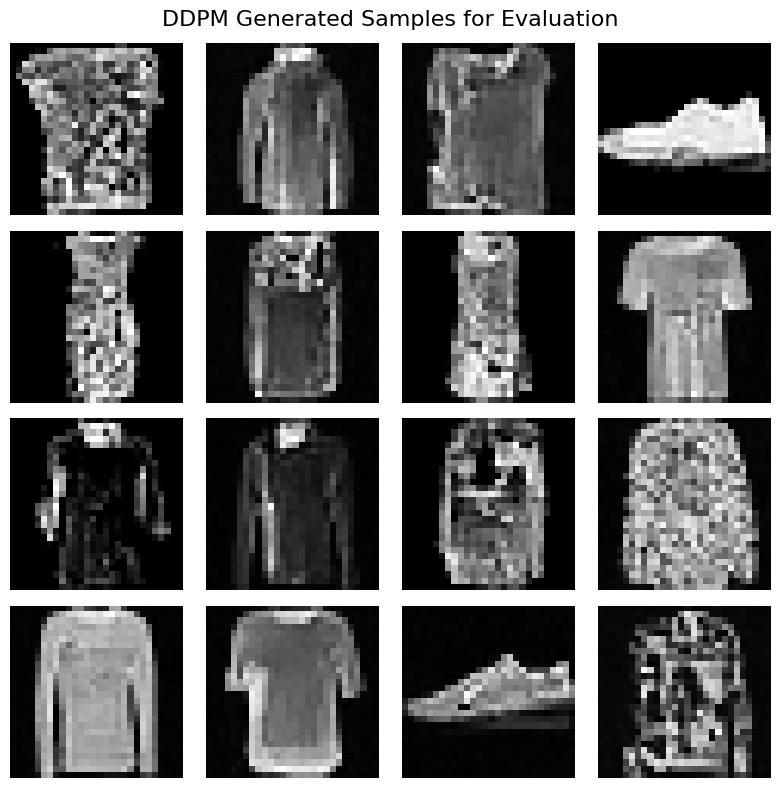

In [13]:
# Visualize some generated samples
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(16):
    axes[i // 4, i % 4].imshow(generated_samples[i, 0], cmap='gray')
    axes[i // 4, i % 4].axis('off')
plt.suptitle('DDPM Generated Samples for Evaluation', fontsize=16)
plt.tight_layout()
plt.show()

## Quantitative Evaluation (FID Score)

In [14]:
# FID evaluation using pytorch-fid (in-memory, no saving)
import sys
import subprocess
import numpy as np
import torch
import torch.nn.functional as F

# Ensure pytorch-fid is installed
try:
    import pytorch_fid
except Exception:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'pytorch-fid'])
    import pytorch_fid

from pytorch_fid.inception import InceptionV3
from pytorch_fid.fid_score import calculate_frechet_distance

num_fid_samples = min(100, generated_samples.shape[0])

# Prepare generated tensor [N,3,299,299] in [0,1]
gen = torch.from_numpy(generated_samples[:num_fid_samples]).float().to(device)
if gen.shape[1] == 1:
    gen = gen.repeat(1, 3, 1, 1)
gen = F.interpolate(gen, size=(299, 299), mode='bilinear', align_corners=False)

# Collect real images from test_loader
real_batches = []
total = 0
for batch_x, _ in test_loader:
    x = torch.clamp((batch_x.to(device) + 1) / 2, 0, 1)  # [-1,1] -> [0,1]
    if x.shape[1] == 1:
        x = x.repeat(1, 3, 1, 1)
    x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
    real_batches.append(x)
    total += x.shape[0]
    if total >= num_fid_samples:
        break
real = torch.cat(real_batches, dim=0)[:num_fid_samples]

# Select feature dimensionality based on sample size
if num_fid_samples >= 2048:
    dims = 2048
elif num_fid_samples >= 768:
    dims = 768
elif num_fid_samples >= 192:
    dims = 192
else:
    dims = 64

# Build InceptionV3
dim_to_block = InceptionV3.BLOCK_INDEX_BY_DIM
block_idx = dim_to_block[dims]
inception = InceptionV3([block_idx]).to(device)
inception.eval()

@torch.no_grad()
def get_acts(x: torch.Tensor, bs: int = 64) -> np.ndarray:
    acts = []
    for i in range(0, x.shape[0], bs):
        out = inception(x[i:i+bs])[0]
        if out.ndim == 4 and (out.shape[2] > 1 or out.shape[3] > 1):
            out = out.mean(dim=(2, 3))
        else:
            out = out.view(out.size(0), -1)
        acts.append(out.cpu().numpy())
    return np.concatenate(acts, axis=0).astype(np.float64)

real_acts = get_acts(real)
gen_acts = get_acts(gen)

mu_r, sigma_r = real_acts.mean(0), np.cov(real_acts, rowvar=False)
mu_g, sigma_g = gen_acts.mean(0), np.cov(gen_acts, rowvar=False)

fid_value = calculate_frechet_distance(mu_r, sigma_r, mu_g, sigma_g)
print(f"FID (pytorch-fid, in-memory, dims={dims}) DDPM vs real: {fid_value:.2f}")

FID (pytorch-fid, in-memory, dims=64) DDPM vs real: 0.19


## Vanilla VAE Benchmark

In [15]:
# Vanilla VAE benchmark on Fashion-MNIST + FID
import torch.nn as nn
import torch.optim as optim

class VanillaVAE(nn.Module):
    def __init__(self, latent_dim: int = 32):
        super().__init__()
        # Encoder: 1x28x28 -> convs -> flatten
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),  # 14x14
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), # 7x7
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, stride=1, padding=1), # 7x7
            nn.ReLU(inplace=True)
        )
        self.enc_out_dim = 128 * 7 * 7
        self.fc_mu = nn.Linear(self.enc_out_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.enc_out_dim, latent_dim)
        
        # Decoder: latent -> deconv to 1x28x28
        self.fc_dec = nn.Linear(latent_dim, self.enc_out_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), # 14x14
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 28x28
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, 3, stride=1, padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(h.size(0), 128, 7, 7)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

@torch.no_grad()
def sample_vae(model: nn.Module, n: int, latent_dim: int) -> torch.Tensor:
    model.eval()
    z = torch.randn(n, latent_dim, device=device)
    x = model.decode(z)
    return x.clamp(0, 1)

VAE epoch 1/50 - loss: 345.0093
VAE epoch 2/50 - loss: 267.1996
VAE epoch 3/50 - loss: 255.8046
VAE epoch 4/50 - loss: 251.0215
VAE epoch 5/50 - loss: 248.2748
VAE epoch 6/50 - loss: 246.4299
VAE epoch 7/50 - loss: 245.0837
VAE epoch 8/50 - loss: 244.2491
VAE epoch 9/50 - loss: 243.2401
VAE epoch 10/50 - loss: 242.6065
VAE epoch 11/50 - loss: 242.0465
VAE epoch 12/50 - loss: 241.5242
VAE epoch 13/50 - loss: 241.1256
VAE epoch 14/50 - loss: 240.7708
VAE epoch 15/50 - loss: 240.4205
VAE epoch 16/50 - loss: 240.0495
VAE epoch 17/50 - loss: 239.8664
VAE epoch 18/50 - loss: 239.4843
VAE epoch 19/50 - loss: 239.2711
VAE epoch 20/50 - loss: 239.0834
VAE epoch 21/50 - loss: 238.8043
VAE epoch 22/50 - loss: 238.8510
VAE epoch 23/50 - loss: 238.5158
VAE epoch 24/50 - loss: 238.3656
VAE epoch 25/50 - loss: 238.2455
VAE epoch 26/50 - loss: 238.0243
VAE epoch 27/50 - loss: 237.9469
VAE epoch 28/50 - loss: 237.8426
VAE epoch 29/50 - loss: 237.7208
VAE epoch 30/50 - loss: 237.5407
VAE epoch 31/50 - l

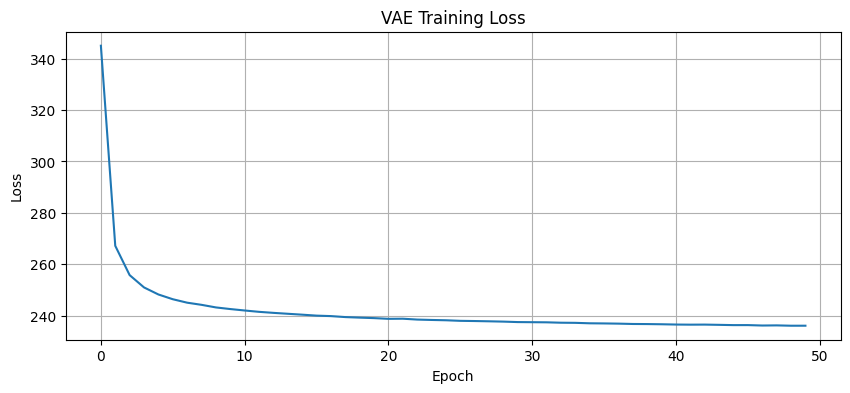

In [16]:
# Train VAE
latent_dim = 32
vae = VanillaVAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

num_epochs = 50
vae_epoch_losses = []
vae.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    num_samples_seen = 0
    for x, _ in train_loader:
        # Map to [0,1] for BCE
        x = torch.clamp((x.to(device) + 1) / 2, 0, 1)
        optimizer.zero_grad()
        recon, mu, logvar = vae(x)
        # Reconstruction + KL
        recon_loss = nn.functional.binary_cross_entropy(recon, x, reduction='sum')
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = (recon_loss + kld) / x.size(0)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        num_samples_seen += x.size(0)
    avg_epoch_loss = total_loss / num_samples_seen
    vae_epoch_losses.append(avg_epoch_loss)
    print(f"VAE epoch {epoch+1}/{num_epochs} - loss: {avg_epoch_loss:.4f}")

# Plot VAE training loss
plt.figure(figsize=(10, 4))
plt.plot(vae_epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.grid(True)
plt.show()

In [17]:
# Generate samples from VAE and compute FID
num_fid_samples = min(100, len(test_dataset))
with torch.no_grad():
    vae_gen = sample_vae(vae, num_fid_samples, latent_dim)

# Prepare VAE generated for FID
if vae_gen.shape[1] == 1:
    vae_gen_rgb = vae_gen.repeat(1, 3, 1, 1)
else:
    vae_gen_rgb = vae_gen
vae_gen_rgb = F.interpolate(vae_gen_rgb, size=(299, 299), mode='bilinear', align_corners=False)

# Compute FID for VAE
vae_gen_acts = get_acts(vae_gen_rgb)
mu_g_vae, sigma_g_vae = vae_gen_acts.mean(0), np.cov(vae_gen_acts, rowvar=False)
fid_value_vae = calculate_frechet_distance(mu_r, sigma_r, mu_g_vae, sigma_g_vae)
print(f"FID (pytorch-fid, in-memory, dims={dims}) VAE vs real: {fid_value_vae:.2f}")

FID (pytorch-fid, in-memory, dims=64) VAE vs real: 0.35


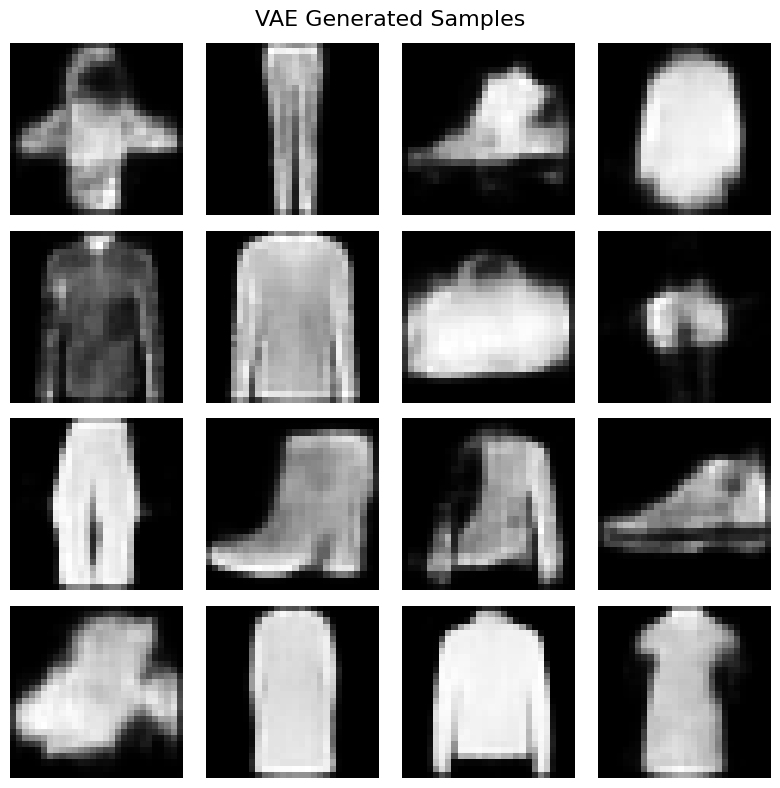

In [18]:
# Visualize VAE generated samples
vae_gen_np = vae_gen.cpu().numpy()

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(16):
    axes[i // 4, i % 4].imshow(vae_gen_np[i, 0], cmap='gray')
    axes[i // 4, i % 4].axis('off')
plt.suptitle('VAE Generated Samples', fontsize=16)
plt.tight_layout()
plt.show()

## Key Points for Training DDPM
1. Use U-Net architecture with self-attention for image generation
2. Linear beta schedule for noise scheduling
3. MSE loss for noise prediction
4. EMA (Exponential Moving Average) for stable sample quality
5. Full reverse diffusion process (1000 steps) for high-quality generation
6. AdamW optimizer with cosine annealing learning rate schedule